In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr
import scipy.stats as stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr
import cloudpickle as pickle

sns.set_context("paper")
simHei = FontProperties(fname=r'/usr/share/fonts/Chinses/simhei.ttf', size=10) 

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score

RANDOM_SEED = 0
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
data = pd.read_csv('../data/第二套数据/PP2_DADA2_ASV.tsv', index_col=0, sep='\t', skiprows=1)
taxon = pd.read_csv('../data/第二套数据/PP2_silva_taxonomy.tsv', index_col=0, sep='\t')
meta = pd.read_excel('../data/Metadata/PP_性早熟-第二批 上传-终版-曹老师给.xlsx', index_col=0, skiprows=1)

In [4]:
len(set(data.columns)), '个菌群测序样'
len(set(data.columns)&set(meta.index)), '个样本具有对应的meta信息'
len(set(data.columns)-set(meta.index)),'个正常样本没有对应的meta信息'
len(set(data.columns)&set(meta.index)-set(['PP210-1', 'PP212-1'])), '有meta信息的样本中去除2个真阳性样本，剩余111个'
samples = list(set(data.columns)&set(meta.index)-set(['PP210-1', 'PP212-1']))
Normal = ['N' in i for i in samples]
PP = ['PP' in i for i in samples]
'正常和PP样本分别为:', sum(Normal), sum(PP)

(147, '个菌群测序样')

(113, '个样本具有对应的meta信息')

(34, '个正常样本没有对应的meta信息')

(111, '有meta信息的样本中去除2个真阳性样本，剩余111个')

('正常和PP样本分别为:', 89, 22)

In [5]:
meta = meta.loc[samples, ['年龄']]
meta['年龄'] = [7.8 if i=='7岁10月' else float(i) for i in meta['年龄']]
data = data.loc[:, samples]

In [6]:
### 第一套年龄统计，正常：7.008（0.515），PP：6.641（0.403）
sum(Normal), meta.loc[Normal, '年龄'].mean(), meta.loc[Normal, '年龄'].std()
sum(PP), meta.loc[PP, '年龄'].mean(), meta.loc[PP, '年龄'].std()

temp = np.array([i for i in meta.loc[Normal, '年龄'] if i<8])
'Normal < 8:', len(temp), temp.mean(), temp.std()
temp = np.array([i for i in meta.loc[PP, '年龄'] if i<8])
'PP < 8:', len(temp), temp.mean(), temp.std()

samples = meta.loc[(meta['年龄']<8), :].index
data = data.loc[:, samples]
data.shape

(89, 6.696629213483146, 1.9271062525668712)

(22, 7.163636363636365, 1.1862487712053265)

('Normal < 8:', 66, 5.787878787878788, 0.9772433634301272)

('PP < 8:', 17, 6.847058823529412, 1.1303917317142884)

(4930, 83)

In [7]:
### 与第一套同样处理方式
ASV_MIN_SAMPLE_COVER_RATE = 0.5
data = data/data.sum() * 100. # 百分比转换
asv_select = (data!=0).sum(1)/float(data.shape[1]) >= ASV_MIN_SAMPLE_COVER_RATE
'原始数据ASV：', data.shape[0], '样本覆盖度>='+str(ASV_MIN_SAMPLE_COVER_RATE)+'的ASV：', sum(asv_select)
data = data.loc[asv_select, :]
data.shape

('原始数据ASV：', 4930, '样本覆盖度>=0.5的ASV：', 102)

(102, 83)

### Difference analysis

In [8]:
from scipy.stats import fisher_exact, ranksums
import statsmodels.stats.multitest as multi

statistic_asv = []
for asv in data.index:
    row = []
    normal_abun = data.loc[asv, [i for i in data.columns if i[0]=='N']]
    pp_abun = data.loc[asv, [i for i in data.columns if i[0]=='P']]
    species = taxon.loc[asv, 'Taxon'].split(';D_6__')[1] if ';D_6__' in taxon.loc[asv, 'Taxon'] else ''
    row.extend([taxon.loc[asv, 'Taxon'], species, normal_abun.mean(), pp_abun.mean()])
    ### Normal vs F_PP
    f, p_value = ranksums(pp_abun, normal_abun)
    FC = pp_abun.mean()/normal_abun.mean()
    row.extend([FC, p_value])
    statistic_asv.append(row)
statistic_asv = pd.DataFrame(statistic_asv, index = data.index, 
                             columns = ['taxon', 'species', 'Normal_mean', 'PP_mean', 'FC','p_value'])
statistic_asv['FDR'] = multi.multipletests(statistic_asv['p_value'], method = 'fdr_bh')[1]
statistic_asv = statistic_asv.sort_values('p_value')
statistic_asv = statistic_asv.loc[statistic_asv['p_value']<=0.05, :]
statistic_asv.shape

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(27, 7)

In [9]:
### 第一批差异菌
statistic_asv1 = pd.read_csv('Microbiome/differential_asv.csv', index_col=0)
statistic_asv1 = statistic_asv1.loc[statistic_asv1['FDR']<=0.05, :]
taxon1 = pd.read_csv('../data/Microbiome/DADA2_silva_taxonomy.tsv', index_col=0, sep='\t')
statistic_asv1['silva_taxon'] = [taxon1.loc[asv, 'Taxon'] for asv in statistic_asv1.index]
statistic_asv1.head(2)

,Name,Normal_mean,PP_mean,FC,p_value,FDR,silva_taxon
#OTU ID,,,,,,,
44001a72292c6ac78f98d2ffaac23065,Genus Bacteroides(1),8.427262,11.995798,1.423451,0.000557,0.004065,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...
07ad45b0efcbc3f6a2037fb16900edf1,Genus Bacteroides(3),0.631731,1.241125,1.964642,0.000001,0.000054,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...


In [10]:
species = statistic_asv1['silva_taxon']
data2_asv = [i for i in data.index if taxon.loc[i, 'Taxon'] in list(species) and i in statistic_asv.index]
sel_asvs = []
for i in data2_asv:
    s = taxon.loc[i, 'Taxon']
    d1_fc = statistic_asv1.loc[statistic_asv1['silva_taxon']==s, 'FC']
    d2_fc = statistic_asv.loc[i, 'FC']
    if (d1_fc.mean()>1 and d2_fc>1) or (d1_fc.mean()<1 and d2_fc<1):
        sel_asvs.append(i)
        '**', s.split(';D_4__')[1].split(';D_6__')[0], [round(k, 3) for k in list(d1_fc)], round(d2_fc, 3)
    else:
        s.split(';D_4__')[1].split(';D_6__')[0], [round(k, 3) for k in list(d1_fc)], round(d2_fc, 3)
len(sel_asvs)

('**', 'Bacteroidaceae;D_5__Bacteroides', [1.27], 1.324)

('Ruminococcaceae;D_5__Faecalibacterium', [1.87, 1.848], 0.661)

('**', 'Bacteroidaceae;D_5__Bacteroides', [1.423, 1.965, 1.482, 1.857], 1.512)

('**', 'Bacteroidaceae;D_5__Bacteroides', [1.423, 1.965, 1.482, 1.857], 4.211)

('**',
 'Enterobacteriaceae;D_5__Escherichia-Shigella',
 [1.606, 1.39, 1.381],
 1.771)

('Ruminococcaceae;D_5__Faecalibacterium', [1.87, 1.848], 0.605)

('**', 'Enterobacteriaceae', [1.619, 2.113, 2.052], 3.185)

('**', 'Enterobacteriaceae', [1.619, 2.113, 2.052], 3.636)

('**', 'Tannerellaceae;D_5__Parabacteroides', [1.282], 1.654)

('Ruminococcaceae;D_5__Faecalibacterium', [1.87, 1.848], 0.276)

('Ruminococcaceae;D_5__Faecalibacterium', [1.87, 1.848], 0.379)

('**', 'Lachnospiraceae;D_5__[Eubacterium] eligens group', [1.304], 3.589)

('**', 'Enterobacteriaceae', [1.619, 2.113, 2.052], 4.994)

('Tannerellaceae;D_5__Parabacteroides', [1.282], 0.468)

('**', 'Bacteroidaceae;D_5__Bacteroides', [1.423, 1.965, 1.482, 1.857], 4.878)

('**', 'Ruminococcaceae;D_5__Subdoligranulum', [1.359], 1.677)

('Tannerellaceae;D_5__Parabacteroides', [1.282], 0.453)

('**', 'Enterobacteriaceae', [1.619, 2.113, 2.052], 1.597)

('**',
 'Enterobacteriaceae;D_5__Escherichia-Shigella',
 [1.606, 1.39, 1.381],
 1.3)

('Ruminococcaceae;D_5__Flavonifractor', [1.335], 0.377)

13

In [11]:
same_reg_asv = statistic_asv.loc[sorted(sel_asvs), :]
same_reg_asv
same_reg_asv.to_csv('Result/第二套与第一套重合同调差异菌.csv')

,taxon,species,Normal_mean,PP_mean,FC,p_value,FDR
#OTU ID,,,,,,,
264e6087ccd5bd1bddaf8155c8ea94fe,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,,0.768870,1.361853,1.771239,0.011860,0.080648
3ee185ce92565aaf2f53a2501d7d4d8a,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,,0.178396,0.640302,3.589213,0.010768,0.080648
4489b75127d450cf88386784a9d46136,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,,0.086066,0.111859,1.299693,0.035836,0.140588
450c380b18ec09f8ac0d8c0318e1280c,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,,0.109376,0.183403,1.676819,0.038929,0.147067
5c096134f63413d295c847d953c84102,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,,0.754535,1.140484,1.511507,0.026993,0.125149
651ee849d18a989ee1b98a2d7be771fe,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,,0.288557,1.049130,3.635782,0.008420,0.080648
8810da8c60b2a8f3fe620689a85653e2,D_0__Bacteria;D_1__Bacteroidetes;D_2__Bacteroi...,Bacteroides plebeius,0.988159,1.307950,1.323623,0.032955,0.138281
95d6ebed2339cc9ccd5f207e7b5eff4c,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,,0.083621,0.133580,1.597453,0.033892,0.138281
a0650a9dca7bec7f2975ffa29a024dd7,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,,0.181474,0.906247,4.993818,0.011486,0.080648


### Validation modeling

In [12]:
data = data.loc[:, sorted(data.columns)]
X = np.array(data.T.loc[:, same_reg_asv.index])
y = np.array([0 if i[0]=='N' else 1 for i in data.T.index])

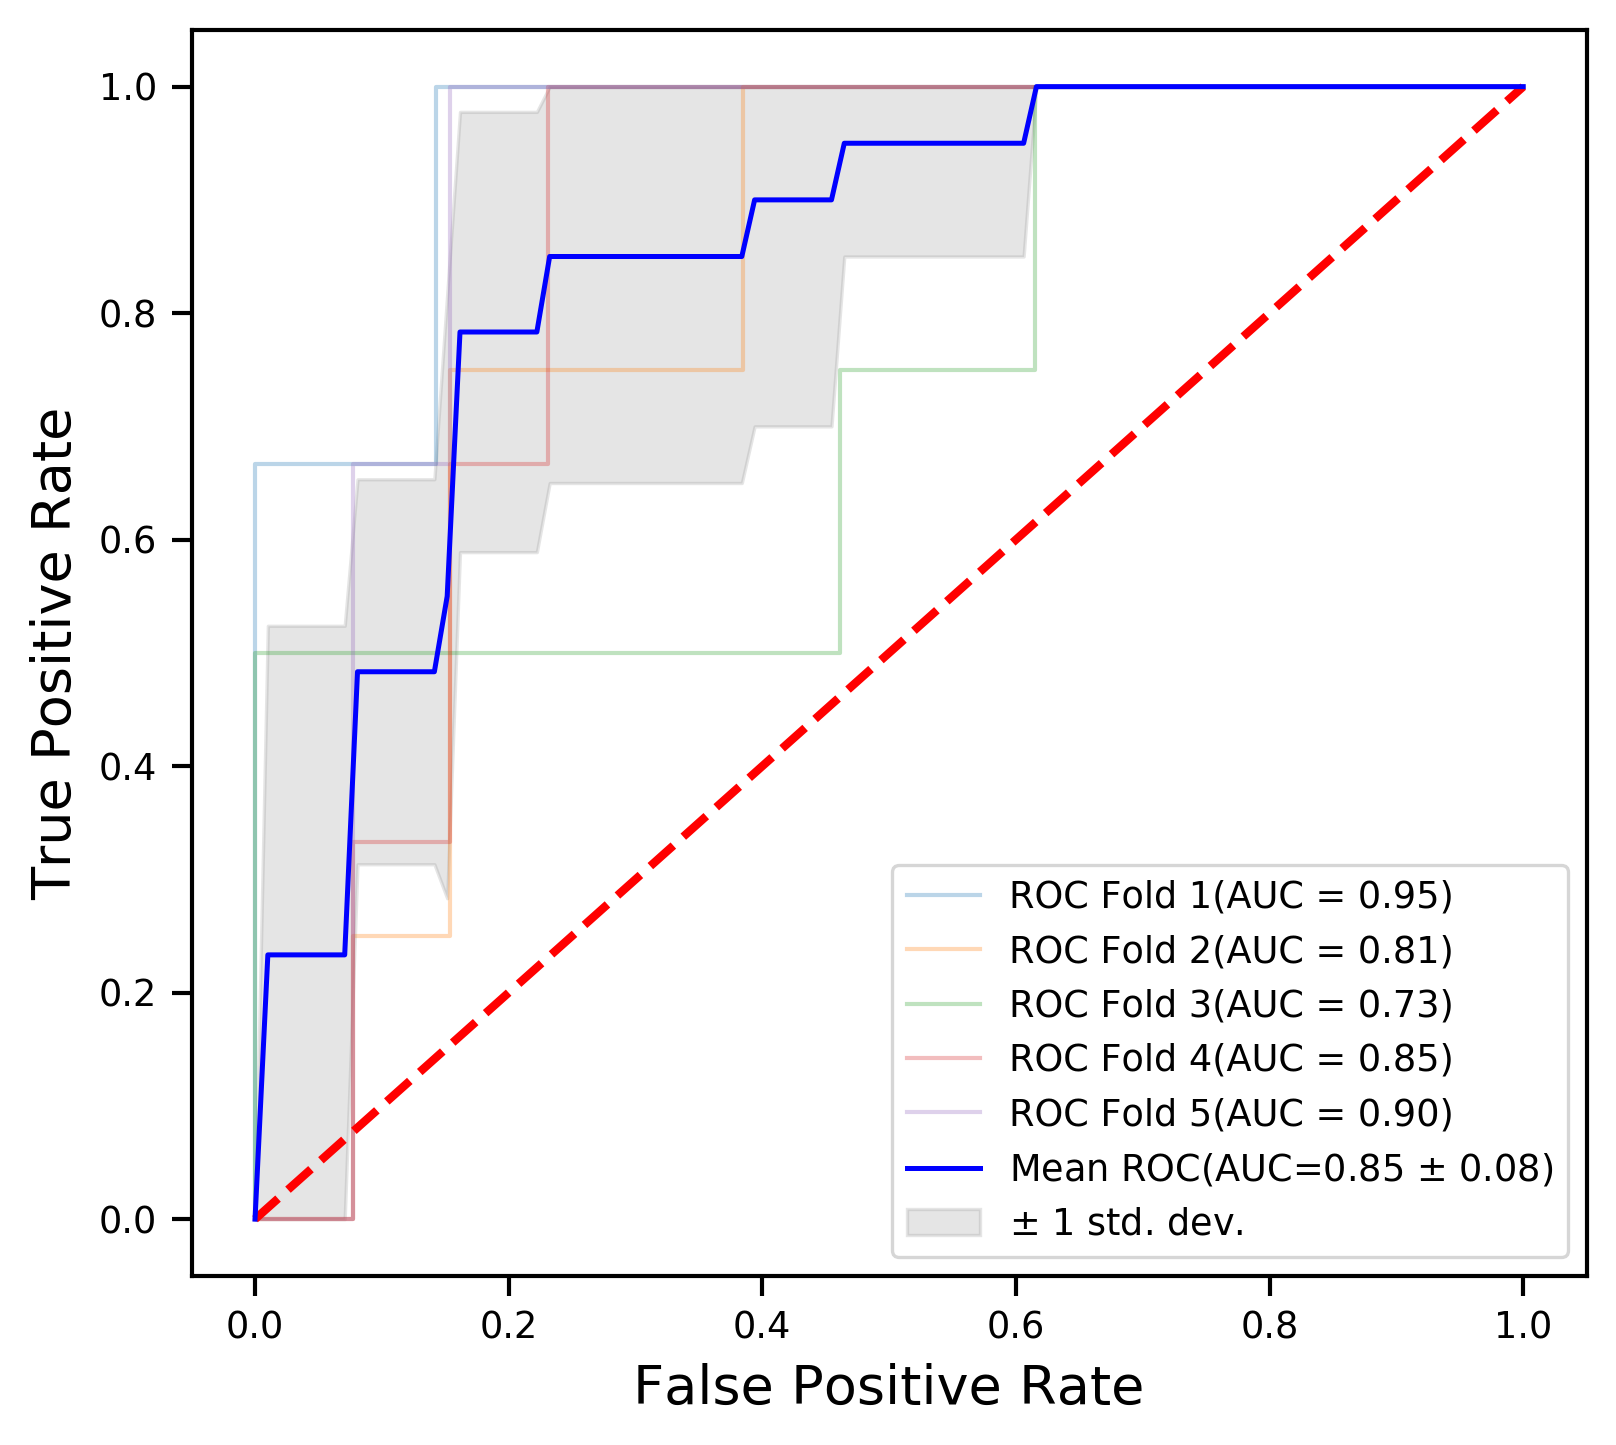

In [13]:
def plot_auc(X, Y, clf):
    plt.figure(1, (6, 5.5), dpi=300)
    k, tprs, aucs, mean_fpr = 0, [], [], np.linspace(0, 1, 100)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) # 随机分5-fold
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        proba = clf.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(Y_test, proba)
        fpr, tpr, thresholds = roc_curve(Y_test, proba) # fpr,tpr 
        #print(k, accuracy_score(Y_test, proba>=0.5))
        aucs.append(auc_score)
        tprs.append(np.interp(mean_fpr, fpr, tpr))#插值
        tprs[-1][0] = 0.0
        _ = plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold %d(AUC = %0.2f)' %(k+1, auc_score)) # k-fold ROC
        k += 1
    _ = plt.plot([0, 1], [0, 1], ls='--', lw=2, color='r')
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    _ = plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    _ = plt.plot(mean_fpr, mean_tpr, color='b', 
                 label='Mean ROC(AUC=%0.2f $\pm$ %0.2f)'%(mean_auc, std_auc)) # k-fold mean ROC
    _ = plt.legend(loc='lower right')
    _ = plt.xlim([-0.05, 1.05])
    _ = plt.ylim([-0.05, 1.05])
    _ = plt.xlabel('False Positive Rate', fontsize=13)
    _ = plt.ylabel('True Positive Rate', fontsize=13)
    plt.show()
clf = RandomForestClassifier(n_estimators=501, max_depth=5, class_weight='balanced', random_state=RANDOM_SEED)
plot_auc(X, y, clf)